# Sentence Embedding - Présentation générale

* Ce notebook présente différentes techniques de "Sentence Embeddings", permettant de générer des features à partir de phrases (ici des tweets)
* L'objectif est de pouvoir séparer les sentiments des tweets de façon automatique, via un T-SNE, qui permet une réduction des features en 2 dimensions
* C'est un notebook d'exemples afin de mieux comprendre la mise en oeuvre des techniques. Il n'est pas optimisé et doit être adapté à un nouveau contexte, en particulier sur les points suivants :
    * Le nettoyage des textes
    * les modèles BERT (model_type) idéalement pré-entraînés sur des données similaires au contexte (ici le modèle 'cardiffnlp/twitter-roberta-base-sentiment' surperforme le modèle de base car il a été pré-entraîné sur des tweets)
    * La taille des vecteurs (max_length)
    * Le batch_size
    * La perplexité du Tsne (perplexity à 30 par défaut)

# Préparation initiale dataset

## Récupération du dataset et filtres de données

In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:

try:
    from google.colab import drive
    drive.mount('/content/drive')
    data_T0=pd.read_csv("/content/drive/MyDrive/Notebooks/P6/Dataset/sample.csv")
        
except ModuleNotFoundError :
    
    data_T0 = pd.read_csv("Dataset\sample.csv")
    

print(data_T0.shape)




Mounted at /content/drive
(1050, 15)


In [3]:
import nltk

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
data_T0.describe(include = "all")

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
count,1050,1050,1050,1050,1050,1050,1049.000000,1049.000000,1050,1050,1050,1050,1050,712,1049
unique,1050,149,1050,1050,642,1050,NaN,NaN,1050,2,1050,27,27,490,984
top,55b85ea15a1536d46b7190ad6fff8ce7,2015-12-01 12:40:44 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",CRNEG7BKMFFYHQ8Z,NaN,NaN,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,PRINT SHAPES,"{""product_specification""=>[{""key""=>""Type"", ""va..."
freq,1,150,1,1,56,1,NaN,NaN,1,993,1,889,889,11,22
mean,NaN,NaN,NaN,NaN,NaN,NaN,2186.197331,1584.527169,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,7639.229411,7475.099680,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,555.000000,340.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,999.000000,600.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,1999.000000,1199.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data_T0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [7]:
data_T0.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [8]:
data_T0.fillna(value='missing', inplace=True) #rajout 

In [9]:
data_T=data_T0

## Nettoyage du texte

In [10]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ').replace('\}', ' ').replace('\{', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

In [11]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ').replace('\}', ' ').replace('\{', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

In [12]:
data_T['product_name_bow'] = data_T0['product_name'].apply(lambda x : transform_bow_fct(x))
data_T['product_name_lem'] = data_T0['product_name'].apply(lambda x : transform_bow_lem_fct(x))
data_T['product_name_dl'] = data_T0['product_name'].apply(lambda x : transform_dl_fct(x))

data_T['product_category_tree_bow'] = data_T0['product_category_tree'].apply(lambda x : transform_bow_fct(x))
data_T['product_category_tree_lem'] = data_T0['product_category_tree'].apply(lambda x : transform_bow_lem_fct(x))
data_T['product_category_tree_dl'] = data_T0['product_category_tree'].apply(lambda x : transform_dl_fct(x))

data_T['description_bow'] = data_T0['description'].apply(lambda x : transform_bow_fct(x))
data_T['description_lem'] = data_T0['description'].apply(lambda x : transform_bow_lem_fct(x))
data_T['description_dl'] = data_T0['description'].apply(lambda x : transform_dl_fct(x))

In [13]:
def accolade(col):
    return col.apply(lambda x: re.sub(r'\{|\}', ' ', str(x))) #rajout

In [14]:
data_T0['product_specifications2'] = accolade(data_T0['product_specifications'])

In [15]:
data_T['product_specifications_bow'] = data_T0['product_specifications2'].apply(lambda x : transform_bow_fct(x))
data_T['product_specifications_lem'] = data_T0['product_specifications2'].apply(lambda x : transform_bow_lem_fct(x))
data_T['product_specifications_dl'] = data_T0['product_specifications2'].apply(lambda x : transform_dl_fct(x))

In [16]:
data_T.shape

(1050, 28)

In [17]:
data_T.to_csv("basep6.csv")

# Préparation commune des traitements

In [18]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere


## Lecture dataset

In [19]:
data_T =  pd.read_csv("basep6.csv")
print(data_T.shape)

(1050, 29)


In [20]:
from nltk.tokenize import sent_tokenize, word_tokenize

data_T['product_name_length_bow'] = data_T['product_name_bow'].apply(lambda x : len(word_tokenize(x)))
print("product_name_max length bow : ", data_T['product_name_length_bow'].max())
data_T['product_name_length_dl'] = data_T['product_name_dl'].apply(lambda x : len(word_tokenize(x)))
print("product_name max length dl : ", data_T['product_name_length_dl'].max())

data_T['product_category_tree_length_bow'] = data_T['product_category_tree_bow'].apply(lambda x : len(word_tokenize(x)))
print("product_category_tree max length bow : ", data_T['product_category_tree_length_bow'].max())
data_T['product_category_tree_length_dl'] = data_T['product_name_dl'].apply(lambda x : len(word_tokenize(x)))
print("product_category_tree max length dl : ", data_T['product_category_tree_length_dl'].max())

data_T['description_length_bow'] = data_T['description_bow'].apply(lambda x : len(word_tokenize(x)))
print("description length max bow : ", data_T['description_length_bow'].max())
data_T['description_length_dl'] = data_T['description_dl'].apply(lambda x : len(word_tokenize(x)))
print("description length max dl : ", data_T['description_length_dl'].max())

product_name_max length bow :  24
product_name max length dl :  30
product_category_tree max length bow :  26
product_category_tree max length dl :  30
description length max bow :  379
description length max dl :  632


In [21]:
data_T['product_specifications_length_bow'] = data_T['product_specifications_bow'].apply(lambda x : len(word_tokenize(x)))
print("product_specifications max length bow : ", data_T['product_specifications_length_bow'].max())
data_T['product_specifications_length_dl'] = data_T['product_specifications_dl'].apply(lambda x : len(word_tokenize(x)))
print("product_specifications max length dl : ", data_T['product_specifications_length_dl'].max())

data_T['product_category_tree_length_bow'] = data_T['product_category_tree_bow'].apply(lambda x : len(word_tokenize(x)))
print("product_category_tree mac length bow : ", data_T['product_category_tree_length_bow'].max())
data_T['product_category_tree_length_dl'] = data_T['product_category_tree_dl'].apply(lambda x : len(word_tokenize(x)))
print("product_category_treee max length dl : ", data_T['product_category_tree_length_dl'].max())

product_specifications max length bow :  451
product_specifications max length dl :  1174
product_category_tree mac length bow :  26
product_category_treee max length dl :  47


## Fonctions communes

In [22]:
# Créer une nouvelle colonne "category"
data_T["category"] = data_T["product_category_tree"].apply(lambda x: x.split(">>")[0].strip())
# Supprimer les caractères inutiles
data_T['category'] = data_T['category'].apply(lambda x: re.sub(r'[\[\]" ]', '', x))
data_T['category']                                                               

0       HomeFurnishing
1             BabyCare
2             BabyCare
3       HomeFurnishing
4       HomeFurnishing
             ...      
1045          BabyCare
1046          BabyCare
1047          BabyCare
1048          BabyCare
1049          BabyCare
Name: category, Length: 1050, dtype: object

In [23]:
#sauvegarde de le base MAJ de catégory
data_T.to_csv("basep6.csv")

In [24]:
# Obtenir la liste des catégories uniques
l_cat = list(set(data_T["category"]))

# Afficher la liste des catégories
print("catégories : ", l_cat)

catégories :  ['HomeFurnishing', 'Computers', 'Kitchen&Dining', 'BeautyandPersonalCare', 'Watches', 'HomeDecor&FestiveNeeds', 'BabyCare']


In [25]:
y_cat_num = [(1-l_cat.index(data_T.iloc[i]['category'])) for i in range(len(data_T))]


In [26]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    #ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    #ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie",bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Représentation des produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    #ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters",bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Représentation des produits par clusters')
    
    plt.suptitle("Représentation des produits avec un score ARI de {}".format(ARI), fontsize=14, fontweight='bold')
    plt.show()
    print("ARI : ", ARI)
    
    
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

""" def TSNE_visu_fct2(X, y, labels, ARI):
    # Perform t-SNE
    #X_tsne = TSNE(n_components=2, perplexity=30, learning_rate=200,                  random_state=0).fit_transform(X)
    #y_cat_num = pd.Categorical(y).codes
    
    # Plot t-SNE visualization
    fig, ax = plt.subplots(figsize=(15, 6))
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap='tab10')
    
    # Add legend outside the plot
    #ax.legend(handles=scatter.legend_elements()[0], labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add ARI score as a title
    plt.title(f"t-SNE Visualization (ARI={ARI:.3f})")
    plt.show()

    TSNE_visu_fct2(X_tsne, y_cat_num, labels, ARI)"""


' def TSNE_visu_fct2(X, y, labels, ARI):\n    # Perform t-SNE\n    #X_tsne = TSNE(n_components=2, perplexity=30, learning_rate=200,                  random_state=0).fit_transform(X)\n    #y_cat_num = pd.Categorical(y).codes\n    \n    # Plot t-SNE visualization\n    fig, ax = plt.subplots(figsize=(15, 6))\n    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap=\'tab10\')\n    \n    # Add legend outside the plot\n    #ax.legend(handles=scatter.legend_elements()[0], labels=labels, bbox_to_anchor=(1.05, 1), loc=\'upper left\')\n    \n    # Add ARI score as a title\n    plt.title(f"t-SNE Visualization (ARI={ARI:.3f})")\n    plt.show()\n\n    TSNE_visu_fct2(X_tsne, y_cat_num, labels, ARI)'

# Bag of word - Tf-idf

## Préparation sentences

In [27]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)


#feat ='description_lem' #cv 0.394 tfidf 0.428
#feat= 'product_name_lem' # cv : 0.34 tfidf 0.51 
#feat = 'product_specifications_lem' #cf : 0.49 tfidf 0.6558 

data_T['toute_info'] = data_T.apply(lambda row: row['description_lem'] + ' ' + row['product_name_lem'] + ' ' + row['product_specifications_lem'], axis=1)
#feat = 'toute_info' # cv 0.60 tfidf 0.6646
#feat = "product_category_tree_lem" # cv 0.899 tfidf 0.969
data_T['toute_info_dl'] = data_T.apply(lambda row: row['description_dl'] + ' ' + row['product_name_dl'] + ' ' + row['product_specifications_dl'],axis=1)
feat = 'toute_info_dl' #0.5689 TFIDF 0.6332
                                                                                                                    
cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])  
ctf_transform = ctf.transform(data_T[feat])  

In [28]:
#sauvegarde de le base MAJ de catégory
data_T.to_csv("basep6.csv")
print (data_T.shape)

(1050, 40)


#fait concatener toutes les chaines de caracteres dans une seule colonne ? 

## Exécution des modèles

CountVectorizer : 
-----------------
ARI :  0.5689 time :  21.0



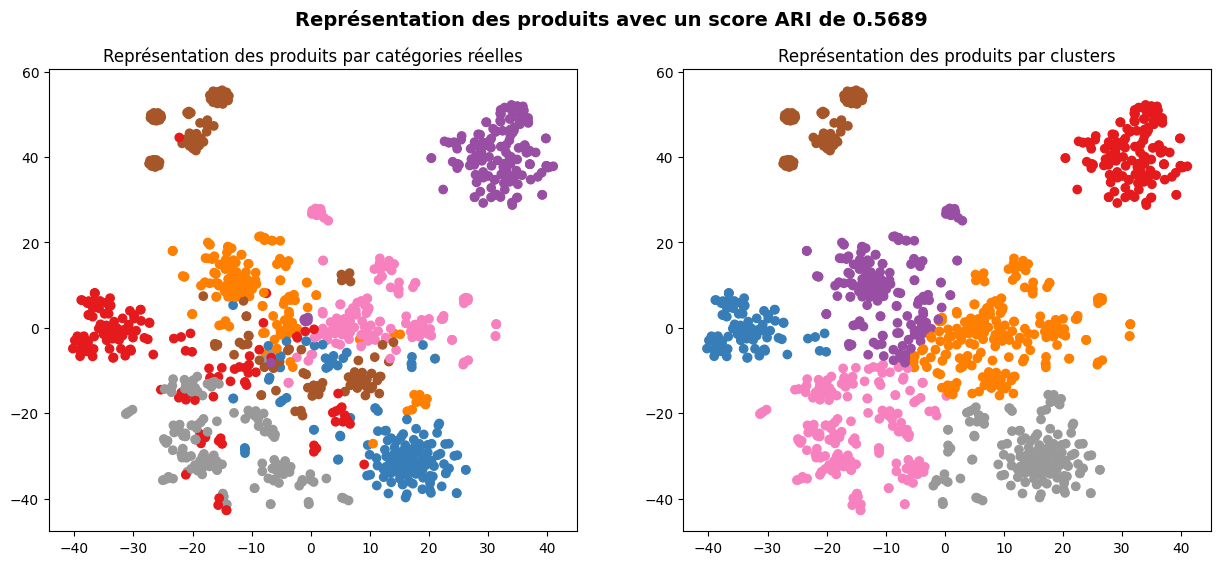

In [29]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [30]:
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)

ARI :  0.5689
Tf-idf : 
--------
ARI :  0.6332 time :  18.0


## Graphiques

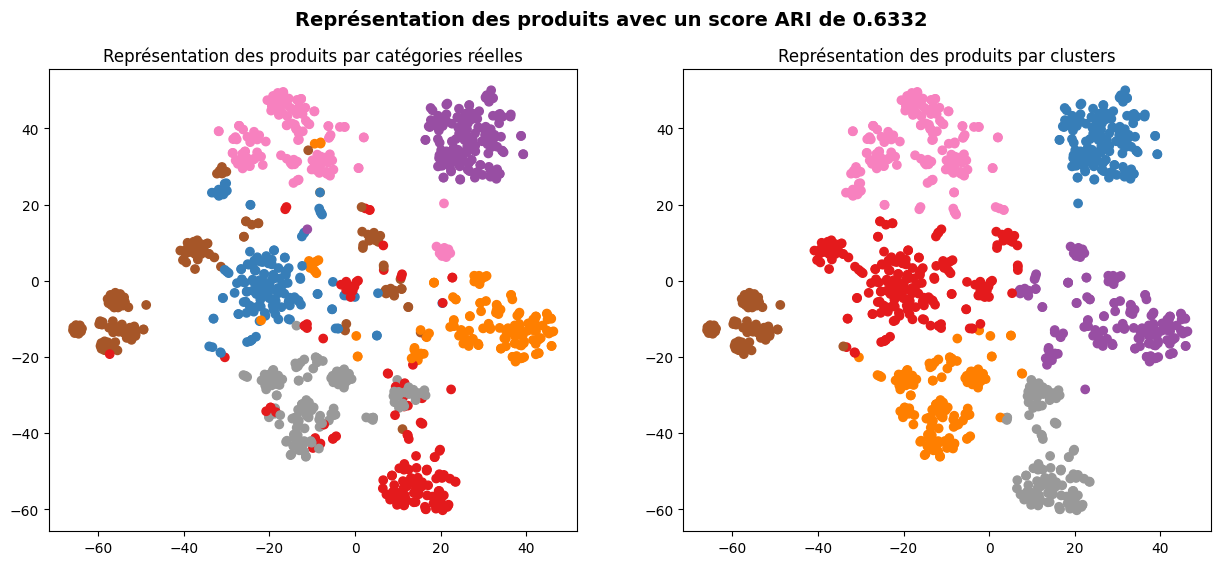

ARI :  0.6332


In [31]:

TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)


# Word2Vec

In [32]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

## Création du modèle Word2Vec

In [33]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data_T['toute_info_dl'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [34]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 6021
Word2Vec trained


In [35]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 6022


## Création de la matrice d'embedding

In [36]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (6022, 300)


## Création du modèle d'embedding

In [37]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1806600   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,806,600
Trainable params: 1,806,600
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [38]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 2ms/step


(1050, 300)

In [39]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.5006 time :  15.0


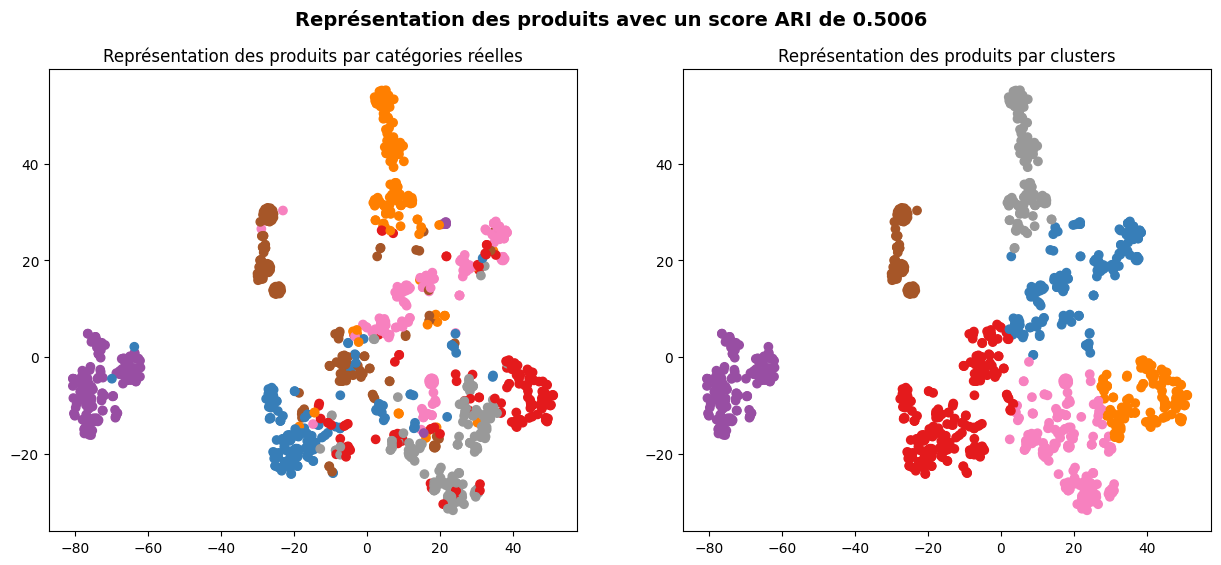

ARI :  0.5006


In [40]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [41]:
#TSNE_visu_fct2(X_tsne, y_cat_num, labels, ARI)

# BERT

In [42]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model



!pip install transformers

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(


In [43]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.12.0
2.12.0
Num GPUs Available:  0
True


## Fonctions communes

In [44]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [71]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
#sentences = data_T['sentence_dl'].to_list()

#sentences = data_T['toute_info_dl'].to_list() # ari 0.3799
sentences = data_T['toute_info'].to_list() 

In [72]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 2s 2s/step
temps traitement :  314.0


In [73]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.4468 time :  21.0


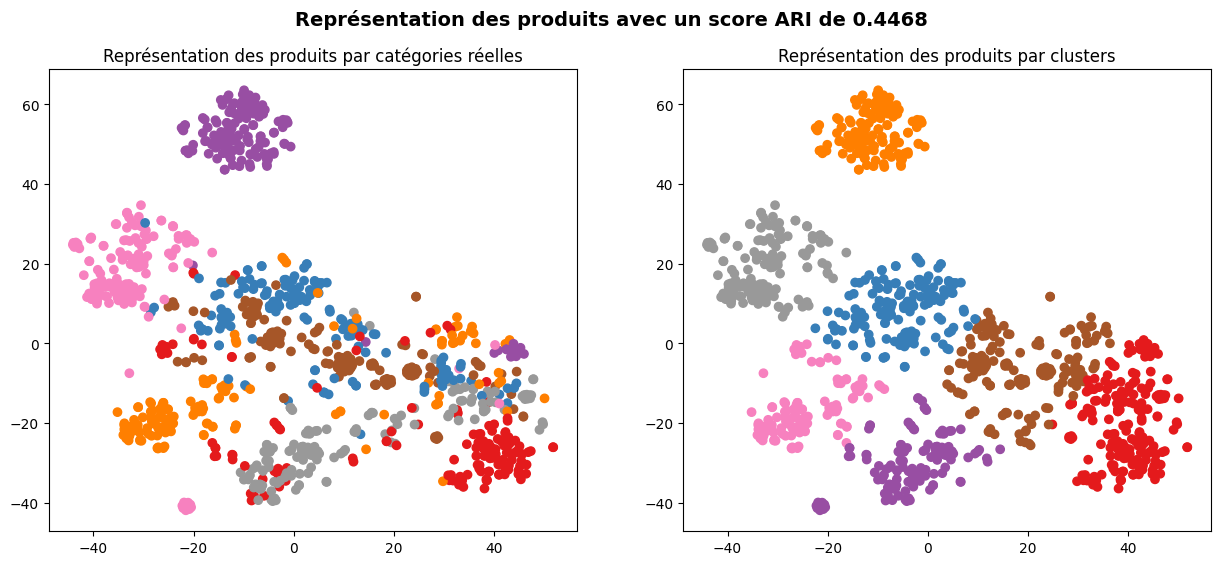

ARI :  0.4468


In [74]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### 'cardiffnlp/twitter-roberta-base-sentiment'
* Modèle pré-entraîné sur des tweets pour l'analyse de sentiment = particulièrement peu adapté au contexte

In [49]:
max_length = 64
batch_size = 10
model_type = 'cardiffnlp/twitter-roberta-base-sentiment'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['toute_info_dl'].to_list()

In [50]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 3s 3s/step
temps traitement :  298.0


In [51]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.2006 time :  21.0


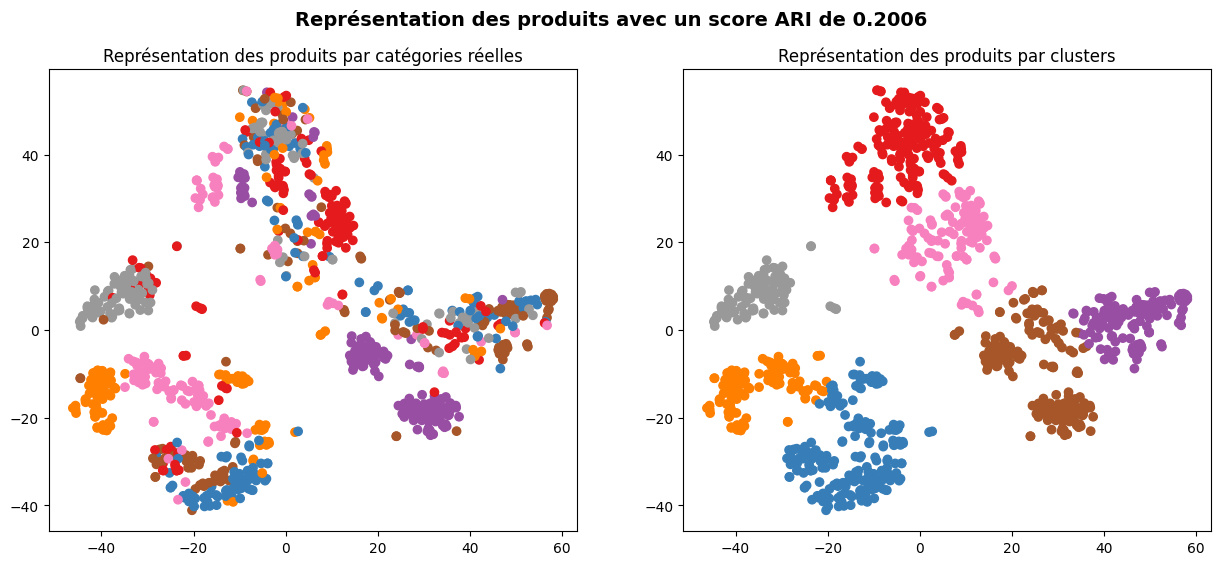

ARI :  0.2006


In [52]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [53]:
# TSNE_visu_fct2(X_tsne, y_cat_num, labels, ARI)

# USE - Universal Sentence Encoder

In [54]:
import os
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [55]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.12.0
2.12.0
Num GPUs Available:  0
True


In [56]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [57]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [58]:
batch_size = 10
sentences = data_T['toute_info_dl'].to_list()

In [59]:
features_USE = feature_USE_fct(sentences, batch_size)

In [60]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.7068 time :  16.0


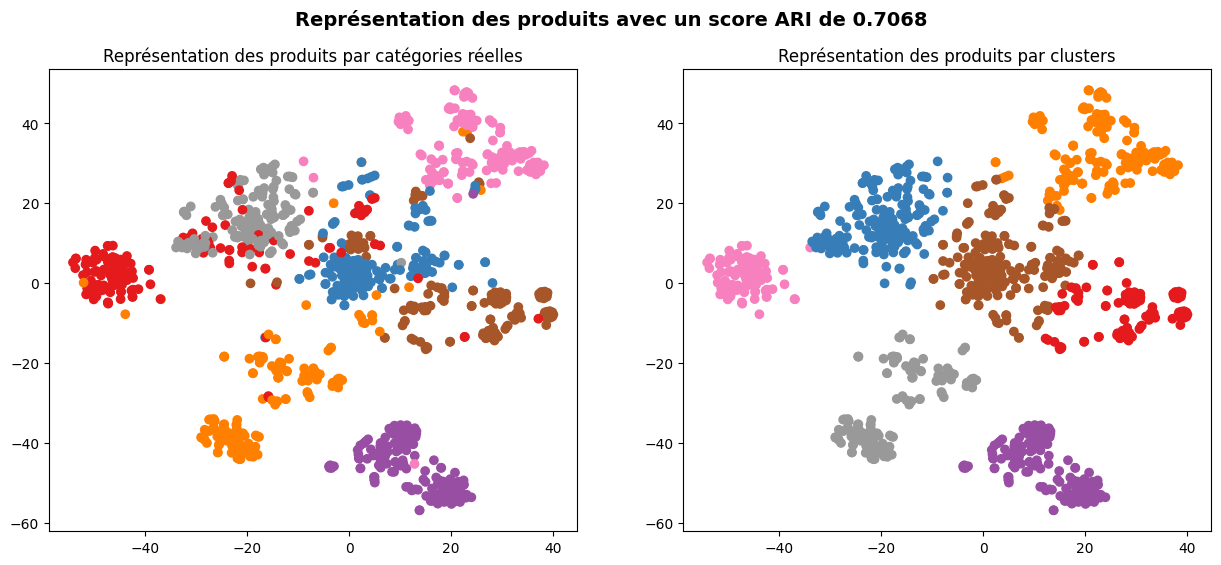

ARI :  0.7068


In [61]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# BERT hub Tensorflow

In [62]:
import tensorflow_hub as hub
!pip install tensorflow-text
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 50.0 MB/s eta 0:00:00


In [67]:
#sentences = data_T['toute_info_dl'].to_list() #0.3634 ARI 
sentences = data_T['toute_info'].to_list() # 0.4133 ARI 

In [68]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  285.0


In [69]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.4133 time :  19.0


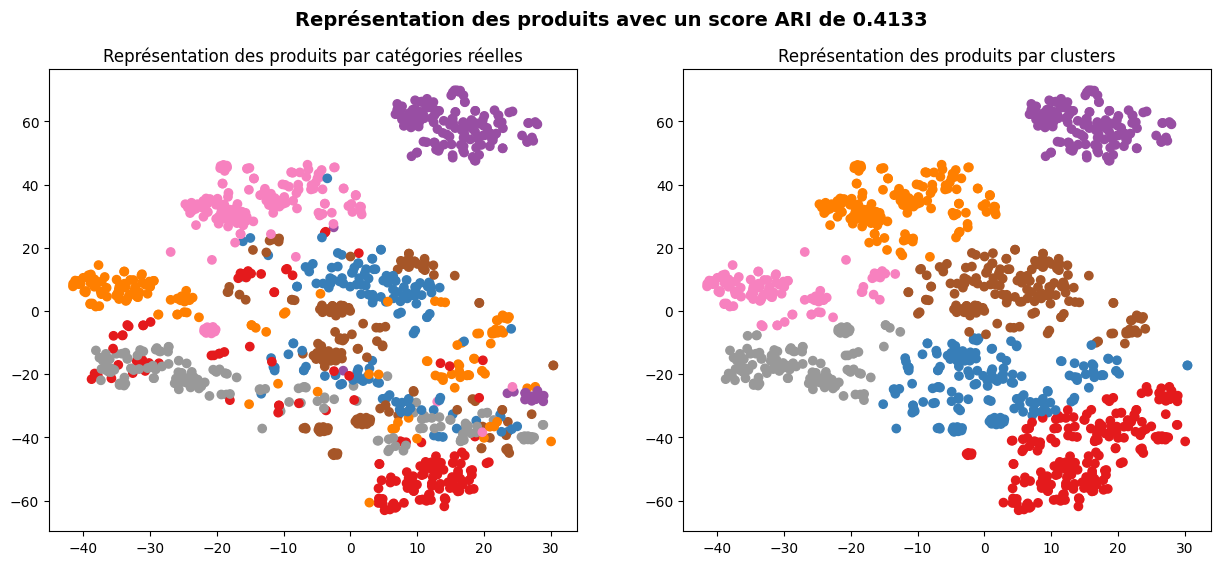

ARI :  0.4133


In [70]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)